[Deep Learning Summer School 2019](http://2019.dl-lab.eu) in Gdansk, Poland  
**Ordinal Regression Tutorial** by [Sebastian Raschka](https://sebastianraschka.com)  
GitHub Repository: https://github.com/rasbt/DL-Gdansk2019-tutorial  

# 02.1 -- Learning How to Implement a Custom Data Loader

## Imports and Settings

In [1]:
import time
import numpy as np
import torch.nn.functional as F
import torch
import pandas as pd

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

Device: cuda:0


In [4]:
BATCH_SIZE = 128

## Another Look at the Built-In MNIST DataLoader

In [5]:
##########################
### MNIST DATASET
##########################

train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



# Note transforms.ToTensor() scales input images
# to 0-1 range

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

valid_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=False)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())



train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=1,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [6]:
torch.manual_seed(123)

# Check that validation splits are not all from 1 class

for images, labels in valid_loader:  
    pass
print(labels[:10])

tensor([6, 0, 6, 6, 7, 6, 4, 6, 4, 1])


## Implementing a Custom DataLoader (assuming MNIST is your "own" dataset)

Illustration of how we can efficiently iterate through custom (image) datasets. For this, suppose 
- mnist_train, mnist_valid, and mnist_test are image folders you created with your own custom images
- mnist_train.csv, mnist_valid.csv, and mnist_test.csv are tables that store the image names with their associated class labels

### 1) Inspecting the dataset

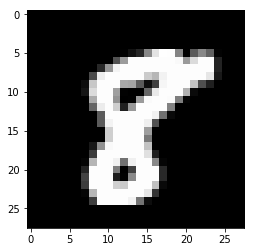

In [7]:
im = Image.open('02_dataloader_files/mnist_train/1.png')
plt.imshow(im, cmap='binary');

In [8]:
im_array = np.array(im)
print('Array Dimensions', im_array.shape)
print()
print(im_array)

Array Dimensions (28, 28)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1  18  38 136 227 255
  254 132   0  90 136  98   3   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  82 156 253 253 253 253 253
  253 249 154 219 253 253  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0  40 150 244 253 253 253 253 253 253
  253 253 253 253 253 253  35   0   0   0]
 [  0   0   0   0   0   0   0   0  74

In [9]:
df_train = pd.read_csv('02_dataloader_files/mnist_train.csv')
print(df_train.shape)
df_train.head()

(256, 2)


,Class Label,File Name
0,5,0.png
1,8,1.png
2,8,2.png
3,0,3.png
4,9,4.png


In [10]:
df_test = pd.read_csv('02_dataloader_files/mnist_test.csv')
print(df_test.shape)
df_test.head()

(256, 2)


,Class Label,File Name
0,4,512.png
1,0,513.png
2,6,514.png
3,8,515.png
4,4,516.png


## 2) Creating a Custom Dataset Class

In [11]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import os



class MyDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

## 3) Creating Custom DataLoaders

In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader


train_indices = torch.arange(0, 150).numpy()
valid_indices = torch.arange(150, 256).numpy()

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.), # not necessary
                                       transforms.ToTensor()
                                      ])

train_dataset = MyDataset(csv_path='02_dataloader_files/mnist_train.csv',
                          img_dir='02_dataloader_files/mnist_train',
                          transform=custom_transform)

test_dataset = MyDataset(csv_path='02_dataloader_files/mnist_test.csv',
                          img_dir='02_dataloader_files/mnist_test',
                          transform=custom_transform)



train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=train_sampler)

valid_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

In [13]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [14]:
# Checking the dataset
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([106, 1, 28, 28])
Image label dimensions: torch.Size([106])


In [15]:
# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## 4) Iterating through the Dataset

The following code cell shows a code block that we would typically use for training a model in PyTorch.

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        
        # train model

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 1 | Batch index: 1 | Batch size: 22
Epoch: 2 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 1 | Batch size: 22


In [17]:
print(x.shape) # note that PyTorch uses NCHW format

torch.Size([22, 1, 28, 28])


In [18]:
x_image_as_vector = x.view(-1, 28*28)
print(x_image_as_vector.shape)

torch.Size([22, 784])


In [19]:
x

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

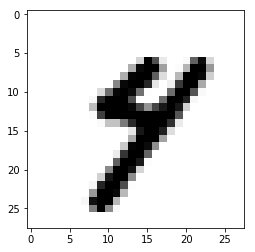

In [21]:
# note that we cannot directly plot gpu tensors via
# matplotlib, hence the .cpu() call
plt.imshow(x[-1, 0, :, :].cpu(), cmap='binary');